# EDA for StackOverflow Dataset

In [1]:
from __future__ import unicode_literals
import bq_helper
from bq_helper import BigQueryHelper
import os
from platform import python_version
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/rahul_kulkarni/creds.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/rosich/Downloads/w266rosich-512999d6c106.json"

In [4]:
##Set up interface to bigquery
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")

## Run a test query

In [4]:
QUERY = "SELECT q.id, q.title, q.body, q.tags, a.body as answers, a.score FROM `bigquery-public-data.stackoverflow.posts_questions` AS q INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a ON q.id = a.parent_id WHERE q.tags LIKE '%python%' LIMIT 50"
df = bq_assistant.query_to_pandas(QUERY)
df.to_csv('data/Original_data.csv')

In [5]:
EN = spacy.load('en_core_web_sm')
df = pd.read_csv('data/Original_data.csv')
df.head()

,Unnamed: 0,id,title,body,tags,answers,score
0,0,30097787,SQLAlchemy long running script: User was holdi...,<p>I have an SQLAlchemy session in a script. T...,python|postgresql|session|transactions|sqlalchemy,<p>I ended up closing the session after (almos...,0
1,1,29992105,Quick way to find all permutations of a pandas...,"<p>I have a DataFrame, and I'd like find all t...",python|sorting|pandas|permutation,"<p>Since you're grouping by age, let's do that...",4
2,2,29992105,Quick way to find all permutations of a pandas...,"<p>I have a DataFrame, and I'd like find all t...",python|sorting|pandas|permutation,<p>You can use numpy to sort like</p>\n\n<bloc...,-2
3,3,29992105,Quick way to find all permutations of a pandas...,"<p>I have a DataFrame, and I'd like find all t...",python|sorting|pandas|permutation,<p>Halfway:</p>\n\n<pre><code>import pandas as...,1
4,4,29992105,Quick way to find all permutations of a pandas...,"<p>I have a DataFrame, and I'd like find all t...",python|sorting|pandas|permutation,<pre><code>import pandas as pd\n\ndf.sort_valu...,-2


In [7]:
print('Database shape:' + str(df.shape))

Database shape:(50, 7)


## Utility Functions for text preprocessing

In [43]:
import re
import nltk
import inflect
from nltk.corpus import stopwords


def tokenize_text(text):
    "Apply tokenization using spacy to docstrings."
    tokens = EN.tokenizer(str(text))
    return [token.text.lower() for token in tokens if not token.is_space]

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def tokenize_code(text):
    "A very basic procedure for tokenizing code strings."
    return RegexpTokenizer(r'\w+').tokenize(text)

def preprocess_text(text):
    return ' '.join(normalize(tokenize_text(text)))

In [9]:
#nltk.download()

# Build the Duplicate Questions Dataset

In [10]:
# Pull in DUPLICATE questions
QUERY = """SELECT q.id, q.title, q.body,
    p.related_post_id,
    d.title AS dupe_title, d.body AS dupe_body , 1 AS is_dupe
FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
INNER JOIN `bigquery-public-data.stackoverflow.post_links` AS p
ON q.id = p.post_id
LEFT JOIN `bigquery-public-data.stackoverflow.posts_questions` AS d
ON p.related_post_id = d.id
WHERE q.tags LIKE '%python%' AND p.link_type_id = 3
LIMIT 100000;"""

In [11]:
df1 = bq_assistant.query_to_pandas(QUERY)
df1.to_csv('data/dupe_qs_100k.csv', index=False)

In [12]:
df1 = pd.read_csv('data/dupe_qs_100k.csv', encoding = 'utf-8')
df1.head()

,id,title,body,related_post_id,dupe_title,dupe_body,is_dupe
0,16267767,"python, writing Json to file",<p>I'm trying to write my first json file. But...,12309269,How do I write JSON data to a file?,<p>I have JSON data stored in the variable <co...,1
1,52385242,How to read from the 5th line in python csv mo...,"<p>for some specific reason, I need to read fr...",27307385,Best way to access the Nth line of csv file,<p>I have to access the Nth line in a CSV file...,1
2,18907551,How to print a list without it showing bracket...,<p>So say I have a list named <code>myList</co...,18816813,Adding all the numbers from a list together(no...,<p>say that I have this list:</p>\n\n<pre><cod...,1
3,27930262,numpy create masked array from lists of unequa...,"<p>I have a list, for example</p>\n\n<pre><cod...",27890052,Convert and pad a list to numpy array,"<p>I have an arbitrarily deeply nested list, w...",1
4,34683264,Wrong timezone? 30min instead 1hr,<p>With this I'm struggling for some hours now...,27531718,Datetime Timezone conversion using pytz,<p>This is just another post on <code>pytz</co...,1


In [13]:
# Pull in RELATED question
QUERY = """SELECT q.id, q.title, q.body,
    p.related_post_id,
    d.title AS dupe_title, d.body AS dupe_body , -1 AS is_dupe
FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
INNER JOIN `bigquery-public-data.stackoverflow.post_links` AS p
ON q.id = p.post_id
LEFT JOIN `bigquery-public-data.stackoverflow.posts_questions` AS d
ON p.related_post_id = d.id
WHERE q.tags LIKE '%python%' AND p.link_type_id = 1
LIMIT 100000;"""

In [14]:
df2 = bq_assistant.query_to_pandas(QUERY)
df2.to_csv('data/related_qs_100k.csv', index=False)

In [15]:
df2 = pd.read_csv('data/related_qs_100k.csv')
df2.head()

,id,title,body,related_post_id,dupe_title,dupe_body,is_dupe
0,56500715,How to solve paramiko output strange format,<p>i'm working on a little automation with pyt...,33291631,Is there a simple way to get rid of junk value...,<p>I am using Python's Paramiko library to SSH...,-1
1,48226944,Calculate Max of Sum of an annotated field ove...,"<p>To keep it simple I have four tables(A, B, ...",43007595,Aggregation of an annotation in GROUP BY in Dj...,<p><strong>UPDATE</strong></p>\n\n<p>Thanks to...,-1
2,48282894,how to store associative data in python,<p>I am new python and would like to know the ...,9161439,Parse key value pairs in a text file,<p>I am a newbie with Python and I search how ...,-1
3,43996951,Read very long array from mat with scipy,<p>I have a result file from Dymola (.mat v4) ...,15644859,How to read specific part of large file in Python,<p>Given a large file (hundreds of MB) how wou...,-1
4,57633222,Decoding data from WIN10 ssh server (response ...,<p>I am using paramiko to connect to a win10 s...,33291631,Is there a simple way to get rid of junk value...,<p>I am using Python's Paramiko library to SSH...,-1


In [16]:
# Pull in questions that are NOT duplicates or related
QUERY = """SELECT q.id, q.title, q.body,
    p.related_post_id,
    d.title AS dupe_title, d.body AS dupe_body , 0 AS is_dupe
FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
LEFT JOIN `bigquery-public-data.stackoverflow.post_links` AS p
ON q.id = p.post_id
LEFT JOIN `bigquery-public-data.stackoverflow.posts_questions` AS d
ON q.tags = d.tags
WHERE q.tags LIKE '%python%' AND d.tags LIKE '%python%' AND p.post_id IS NULL AND q.id <> d.id
LIMIT 100000;"""

In [17]:
df3 = bq_assistant.query_to_pandas(QUERY)
print(df3.shape)
df3.to_csv('data/nondup_qs_100k.csv', index=False, encoding='utf-8')

(100000, 7)


In [18]:
df3 = pd.read_csv('data/nondup_qs_100k.csv',  encoding = 'utf-8')
df3.head(100)

,id,title,body,related_post_id,dupe_title,dupe_body,is_dupe
0,24724263,Custom Python Thread Pool Synchrnoization,<p>I'm trying to create a thread pool in pytho...,NaN,Avoiding deadlocks in Python ThreadPoolExecutor,<p>Python documentation provides example code ...,0
1,24724263,Custom Python Thread Pool Synchrnoization,<p>I'm trying to create a thread pool in pytho...,NaN,A thread pool that lets me know when at least ...,"<p>I need to use a thread pool in python, and ...",0
2,24724263,Custom Python Thread Pool Synchrnoization,<p>I'm trying to create a thread pool in pytho...,NaN,How to stop all threads on KeyboardInterupt wi...,<p>This is my Job class:</p>\n\n<pre><code>cla...,0
3,24724263,Custom Python Thread Pool Synchrnoization,<p>I'm trying to create a thread pool in pytho...,NaN,Can't start new thread,<p>I'm processing all the files in a directory...,0
4,24724263,Custom Python Thread Pool Synchrnoization,<p>I'm trying to create a thread pool in pytho...,NaN,"When doing network programming, is there a rul...","<p>Say I have a list of 1000 unique urls, and ...",0
...,...,...,...,...,...,...,...
95,10871490,How can I add more items to an EmbeddedDocumen...,<p>I'm trying to check if there is already an ...,NaN,"""AttributeError: 'NoneType' object has no attr...",<p>I have the following Python code to connect...,0
96,10871490,How can I add more items to an EmbeddedDocumen...,<p>I'm trying to check if there is already an ...,NaN,Using mongoengine in Django. Cannot save insta...,<p>I am trying to create new Document and save...,0
97,10871490,How can I add more items to an EmbeddedDocumen...,<p>I'm trying to check if there is already an ...,NaN,"How to do ""insert if not exist else update"" wi...","<p>I'm working with mongoengine in Django,<br>...",0
98,10871490,How can I add more items to an EmbeddedDocumen...,<p>I'm trying to check if there is already an ...,NaN,Django: Mongoengine syncdb failed,"<p>I am using <a href=""http://docs.mongoengine...",0


In [19]:
frames = [df1, df3]
df = pd.concat(frames)

In [20]:
final_df = df.drop(['id','body','related_post_id', 'dupe_body'], axis = 1)
final_df

,title,dupe_title,is_dupe
0,"python, writing Json to file",How do I write JSON data to a file?,1
1,How to read from the 5th line in python csv mo...,Best way to access the Nth line of csv file,1
2,How to print a list without it showing bracket...,Adding all the numbers from a list together(no...,1
3,numpy create masked array from lists of unequa...,Convert and pad a list to numpy array,1
4,Wrong timezone? 30min instead 1hr,Datetime Timezone conversion using pytz,1
...,...,...,...
99995,Assigning name to lines read from a file,How to store an input from a user into a speci...,0
99996,Assigning name to lines read from a file,how to convert from longitude and latitude to ...,0
99997,Assigning name to lines read from a file,Python lists.. Two functions... I have the fir...,0
99998,Assigning name to lines read from a file,replace a part of file with another file,0


In [21]:
final_df.title = final_df.title.apply(lambda x: preprocess_text(x))

In [22]:
final_df

,title,dupe_title,is_dupe
0,python writing json file,How do I write JSON data to a file?,1
1,read 5th line python csv module,Best way to access the Nth line of csv file,1
2,print list without showing brackets output pyt...,Adding all the numbers from a list together(no...,1
3,numpy create masked array lists unequal size,Convert and pad a list to numpy array,1
4,wrong timezone 30min instead 1hr,Datetime Timezone conversion using pytz,1
...,...,...,...
99995,assigning name lines read file,How to store an input from a user into a speci...,0
99996,assigning name lines read file,how to convert from longitude and latitude to ...,0
99997,assigning name lines read file,Python lists.. Two functions... I have the fir...,0
99998,assigning name lines read file,replace a part of file with another file,0


In [23]:
final_df.dupe_title = final_df.dupe_title.apply(lambda x: preprocess_text(x))

In [24]:
final_df

,title,dupe_title,is_dupe
0,python writing json file,write json data file,1
1,read 5th line python csv module,best way access nth line csv file,1
2,print list without showing brackets output pyt...,adding numbers list togethernot summing python...,1
3,numpy create masked array lists unequal size,convert pad list numpy array,1
4,wrong timezone 30min instead 1hr,datetime timezone conversion using pytz,1
...,...,...,...
99995,assigning name lines read file,store input user specified index array python,0
99996,assigning name lines read file,convert longitude latitude country city,0
99997,assigning name lines read file,python lists two functions firsti think second,0
99998,assigning name lines read file,replace part file another file,0


In [28]:
final_df.to_csv('data/ss_data_100k.csv', index=False)

# Build the Response ranking dataset

In [7]:
QUERY = """SELECT q.id, q.title, q.body, q.answer_count, a.body as answer,
    CASE WHEN q.accepted_answer_id = a.id THEN 1 ELSE 0 END AS accepted_flag
FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
ON q.id = a.parent_id
WHERE q.tags LIKE '%python%' AND q.accepted_answer_id IS NOT NULL AND q.answer_count > 1
LIMIT 100000"""

In [8]:
df = bq_assistant.query_to_pandas(QUERY)
df.to_csv('data/original_answers.csv', index=False)

In [9]:
df = pd.read_csv('data/original_answers.csv')
df.head()

,id,title,body,answer_count,answer,accepted_flag
0,26496636,Understanding modular arithmetic in encryption...,<p>I understand modular arithmetic in its basi...,3,<p>The mod operator can be used in many differ...,0
1,26496636,Understanding modular arithmetic in encryption...,<p>I understand modular arithmetic in its basi...,3,<p>The modular of 127 us to ensure you stay in...,0
2,26496636,Understanding modular arithmetic in encryption...,<p>I understand modular arithmetic in its basi...,3,<p>in the parts \n<code>\n key_c = ord(...,1
3,55340041,Best practice: how to pass many many arguments...,<p>I am running some <strong>numerical simulat...,2,<p>You could pass in a dictionary like so:</p>...,0
4,55340041,Best practice: how to pass many many arguments...,<p>I am running some <strong>numerical simulat...,2,<p>I don't think this is really a StackOverflo...,1


In [10]:
#indexNames = df[df['accepted_flag'] == 0].index
# Delete these row indexes from dataFrame
#df.drop(indexNames , inplace=True)
pd.set_option('display.max_colwidth', -1)
df.head(10)

,id,title,body,answer_count,answer,accepted_flag
0,26496636,Understanding modular arithmetic in encryption example,"<p>I understand modular arithmetic in its basic mathematical form for example:</p>\n\n<pre><code>38 = 2 mod 12\n</code></pre>\n\n<p>However in the following encryption and decryption code example it is used along with other math and I don't understand what it is used for.</p>\n\n<pre><code>def encrypt(key, msg):\n encryped = []\n for i, c in enumerate(msg):\n key_c = ord(key[i % len(key)])\n msg_c = ord(c)\n encryped.append(chr((msg_c + key_c) % 127))\n return ''.join(encryped)\n\ndef decrypt(key, encryped):\n msg = []\n for i, c in enumerate(encryped):\n key_c = ord(key[i % len(key)])\n enc_c = ord(c)\n msg.append(chr((enc_c - key_c) % 127))\n return ''.join(msg)\n\nif __name__ == '__main__':\n key = 'This_is_my_awsome_secret_key'\n msg = 'Hello world'\n encrypted = encrypt(key, msg)\n decrypted = decrypt(key, encrypted)\n\n print 'Message:', repr(msg)\n print 'Key:', repr(key)\n print 'Encrypted:', repr(encrypted)\n print 'Decrypted:', repr(decrypted)\n</code></pre>\n\n<p>Can someone explain it to me please?</p>",3,"<p>The mod operator can be used in many different ways. In this case, it is used to constrain certain values and to make them ""rotate"".\nExample:</p>\n\n<pre><code>&gt;&gt;&gt; a = [0,1,2,3,4,5]\n&gt;&gt;&gt; f = lambda x : (x + 4) % 6\n&gt;&gt;&gt; print map(f,a)\n[5, 0, 1, 2, 3, 4]\n</code></pre>\n\n<p>As shown here, the function f adds 4 to each index and computes x mod 6 for all the resulting values, yielding an array which effectively has the same values moved 4 places to the right in a circular manner.\nIn many cases, if we call x mod n, we are saying that we want the values to lie between 0 and n-1. This is often used in hashing functions and other functions where we need some large integers to map to a list index, no larger than the length of the list.</p>",0
1,26496636,Understanding modular arithmetic in encryption example,"<p>I understand modular arithmetic in its basic mathematical form for example:</p>\n\n<pre><code>38 = 2 mod 12\n</code></pre>\n\n<p>However in the following encryption and decryption code example it is used along with other math and I don't understand what it is used for.</p>\n\n<pre><code>def encrypt(key, msg):\n encryped = []\n for i, c in enumerate(msg):\n key_c = ord(key[i % len(key)])\n msg_c = ord(c)\n encryped.append(chr((msg_c + key_c) % 127))\n return ''.join(encryped)\n\ndef decrypt(key, encryped):\n msg = []\n for i, c in enumerate(encryped):\n key_c = ord(key[i % len(key)])\n enc_c = ord(c)\n msg.append(chr((enc_c - key_c) % 127))\n return ''.join(msg)\n\nif __name__ == '__main__':\n key = 'This_is_my_awsome_secret_key'\n msg = 'Hello world'\n encrypted = encrypt(key, msg)\n decrypted = decrypt(key, encrypted)\n\n print 'Message:', repr(msg)\n print 'Key:', repr(key)\n print 'Encrypted:', repr(encrypted)\n print 'Decrypted:', repr(decrypted)\n</code></pre>\n\n<p>Can someone explain it to me please?</p>",3,"<p>The modular of 127 us to ensure you stay in ASCII bounds (basically so it's readable). The modular for encrypted just makes a set up that can be undone, and appear random. However, given the keys simplicity, the encrypt can easily be undone the same way it was done.</p>\n\n<p>I would recommend changing the key to just 'key', and write down the steps of encrypt, then decrypt. The pattern will be obvious after that. If you have any questions, feel free to ask.</p>",0
2,26496636,Understanding modular arithmetic in encryption example,"<p>I understand modular arithmetic in its basic mathematical form for example:</p>\n\n<pre><code>38 = 2 mod 12\n</code></pre>\n\n<p>However in the following encryption and decryption code example it is used along with other math and I don't understand what it is used for.</p>\n\n<pre><code>def encrypt(key, msg):\n encryped = []\n for i, c in enumerate(msg):\n key_c = ord(key[i % len(key)])\n msg_c = ord(c)\n encryped.append(c

In [11]:
from bs4 import BeautifulSoup

question_list = [] 
answer_list = []
accepted_flag = []

for i, row in df.iterrows():
    # Question body
    content = row.body
    soup = BeautifulSoup(content, 'lxml')
    if soup.code: soup.code.decompose()
    tag_p = soup.p
    tag_pre = soup.pre
    text = ''
    if tag_p: text = text + tag_p.get_text()
    if tag_pre: text = text + tag_pre.get_text()
    question_list.append(str(text))
    
    # Answers
    content = row.answer
    soup = BeautifulSoup(content, 'lxml')
    if soup.code: soup.code.decompose()
    tag_p = soup.p
    tag_pre = soup.pre
    text = ''
    if tag_p: text = text + tag_p.get_text()
    if tag_pre: text = text + tag_pre.get_text()
    answer_list.append(text)
    
    # Accepted flag
    accepted_flag.append(row.accepted_flag)

df_post = pd.DataFrame({'body': question_list, 'answer' : answer_list, 'accepted_flag' : accepted_flag})

In [12]:
df_post.body = df_post.body.apply(lambda x: preprocess_text(x))

In [13]:
df_post.answer = df_post.answer.apply(lambda x: preprocess_text(x))

In [14]:
df_post.head()

,body,answer,accepted_flag
0,understand modular arithmetic basic mathematical form example,mod operator used many different ways case used constrain certain values make rotate example,0
1,understand modular arithmetic basic mathematical form example,modular 127 us ensure stay ascii bounds basically readable modular encrypted makes set undone appear random however given keys simplicity encrypt easily undone way done,0
2,understand modular arithmetic basic mathematical form example,parts,1
3,running numerical simulations main function must receive lots lots arguments talking 10 30 arguments depending simulation run,could pass dictionary like,0
4,running numerical simulations main function must receive lots lots arguments talking 10 30 arguments depending simulation run,nt think really stackoverflow question software engineering question example check question,1


In [48]:
df_post.to_csv('data/rr_data_100k.csv', index=False)

NameError: name 'df_post' is not defined

# Other EDA

# Duplicate Questions Data Set

In [68]:
# Load in data from file if not already loaded
dupe_df = pd.read_csv('data/ss_data_100k.csv')

In [69]:
dupe_df.describe()

,is_dupe
count,162760.000000
mean,0.385598
std,0.486738
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [70]:
dupe_df = dupe_df.drop(columns=['is_dupe'])

In [71]:
dupe_df = pd.melt(dupe_df)
dupe_df.head()

,variable,value
0,title,python convert string zeros ones binary
1,title,range returns word
2,title,solve error typeerror ca nt convert int object...
3,title,zip function python 3
4,title,display string representation objects list


In [72]:
dupe_df['value'] = dupe_df['value'].astype(str)
dupe_df['variable'].value_counts()

title         162760
dupe_title    162760
Name: variable, dtype: int64

In [74]:
dupe_df['word_count'] = dupe_df['value'].apply(lambda x: len(str(x).split()))

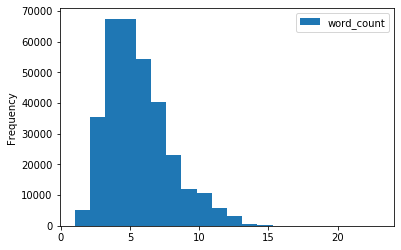

In [78]:
dupe_df.plot.hist(bins=20)

Text(0.5, 0, 'Word Count')

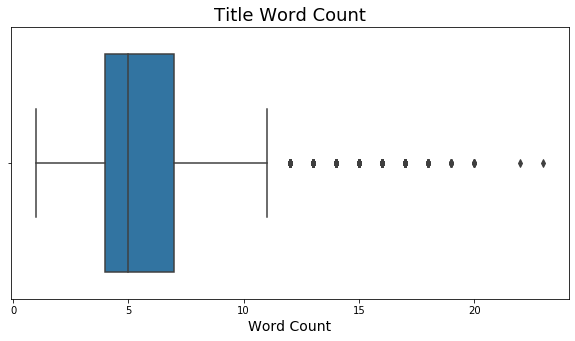

In [79]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'word_count', data = dupe_df, orient="h")
plt.title('Title Word Count', fontsize = 18)
plt.xlabel("Word Count", fontsize = 14)

In [77]:
#Most common words in questions
pd.Series(' '.join(dupe_df['value']).lower().split()).value_counts()[:20]

python       121978
string        37449
list          34703
flask         26294
using         19305
file          18219
error         16513
function      14752
pandas        12796
dataframe     10612
get           10569
values         9847
nt             9527
value          9387
lists          9102
data           8890
_              8439
variable       8410
multiple       8390
django         8093
dtype: int64

In [81]:
#Number of unique words in questions
pd.Series(' '.join(dupe_df['value']).lower().split()).nunique()

23833

# Question and Answer Data Set

In [7]:
rr_df = pd.read_csv('data/rr_data_100k.csv')

In [8]:
rr_df.head()

,id,title,body,answer_count,answer,accepted_flag
0,23366047,Modifying a .py file within Python,p program imports py file contains lists dicti...,2,p instead directly editing py files within py ...,1
1,23366047,Modifying a .py file within Python,p program imports py file contains lists dicti...,2,p use sqlite pickle module instead allow easie...,0
2,23588038,What is a good way to support Python 2 in a Py...,p ive written library python 3 recently pull r...,3,p simplest way support python 2 python 3 code ...,0
3,23588038,What is a good way to support Python 2 in a Py...,p ive written library python 3 recently pull r...,3,p ive released library python 27 well way use ...,1
4,23588038,What is a good way to support Python 2 in a Py...,p ive written library python 3 recently pull r...,3,p would invest much effort supporting python 2...,0


In [9]:
rr_df.describe()

,id,answer_count,accepted_flag
count,1.000000e+05,100000.00000,100000.000000
mean,2.939938e+07,3.81014,0.354260
std,1.845394e+07,3.78078,0.478291
min,1.476000e+03,2.00000,0.000000
25%,1.229954e+07,2.00000,0.000000
50%,2.999474e+07,3.00000,0.000000
75%,4.642853e+07,4.00000,1.000000
max,5.912163e+07,63.00000,1.000000


In [10]:
rr_df['body_word_count'] = rr_df['body'].apply(lambda x: len(str(x).split()))
rr_df['answer_word_count'] = rr_df['answer'].apply(lambda x: len(str(x).split()))

In [11]:
rr_df.head()

,id,title,body,answer_count,answer,accepted_flag,body_word_count,answer_word_count
0,23366047,Modifying a .py file within Python,p program imports py file contains lists dicti...,2,p instead directly editing py files within py ...,1,50,97
1,23366047,Modifying a .py file within Python,p program imports py file contains lists dicti...,2,p use sqlite pickle module instead allow easie...,0,50,14
2,23588038,What is a good way to support Python 2 in a Py...,p ive written library python 3 recently pull r...,3,p simplest way support python 2 python 3 code ...,0,90,29
3,23588038,What is a good way to support Python 2 in a Py...,p ive written library python 3 recently pull r...,3,p ive released library python 27 well way use ...,1,90,77
4,23588038,What is a good way to support Python 2 in a Py...,p ive written library python 3 recently pull r...,3,p would invest much effort supporting python 2...,0,90,196


In [13]:
rr_qs_df = rr_df.drop(['answer','accepted_flag','answer_word_count'], axis = 1).drop_duplicates()

In [25]:
rr_qs_df.describe()

,id,answer_count,body_word_count
count,3.542700e+04,35427.000000,35427.000000
mean,3.188610e+07,2.822706,106.563638
std,1.777055e+07,1.669525,111.808452
min,1.476000e+03,2.000000,4.000000
25%,1.624743e+07,2.000000,51.000000
50%,3.358543e+07,2.000000,80.000000
75%,4.798433e+07,3.000000,128.000000
max,5.912163e+07,63.000000,4703.000000


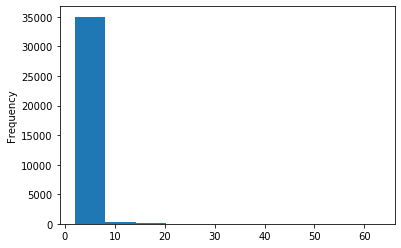

In [19]:
rr_qs_df['answer_count'].plot.hist()

Text(0.5, 0, '# of Answers')

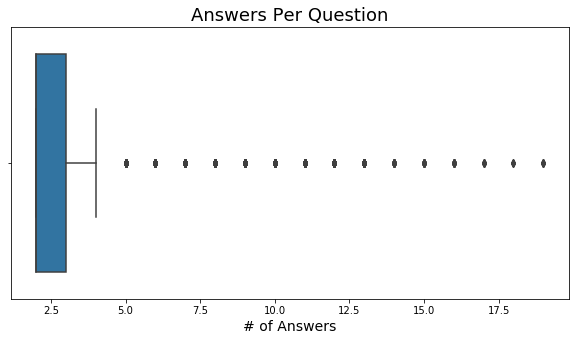

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'answer_count', data = rr_qs_df.loc[(rr_qs_df['answer_count'] < 20)], orient="h")
plt.title('Answers Per Question', fontsize = 18)
plt.xlabel("# of Answers", fontsize = 14)

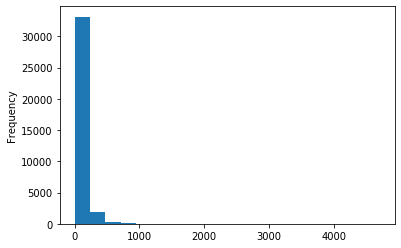

In [22]:
rr_qs_df['body_word_count'].plot.hist(bins=20)

Text(0.5, 0, 'Body Word Count')

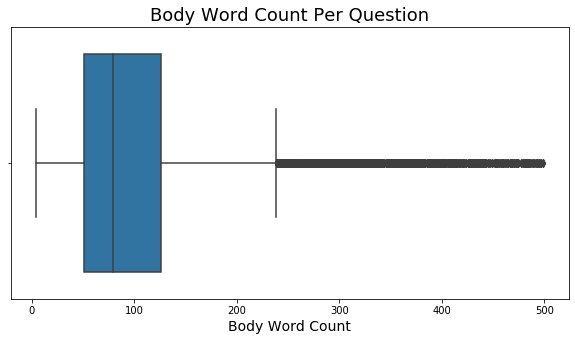

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'body_word_count', data = rr_qs_df.loc[(rr_qs_df['body_word_count'] < 500)] , orient="h")
plt.title('Body Word Count Per Question', fontsize = 18)
plt.xlabel("Body Word Count", fontsize = 14)

In [36]:
#Most common words in body
pd.Series(' '.join(rr_qs_df['body']).lower().split()).value_counts()[:20]

p          171470
codepre     63246
code        51829
precode     51767
_           38838
1           36915
0           33007
file        24251
python      23577
import      22778
2           22121
def         20142
like        18170
line        17538
nt          17167
return      16518
3           16077
print       15596
want        15389
list        14846
dtype: int64

In [37]:
#Number of unique words in questions
pd.Series(' '.join(rr_qs_df['body']).lower().split()).nunique()

411941

In [ ]:
#Answers

In [35]:
rr_as_df = rr_df.filter(['answer','accepted_flag','answer_word_count'], axis=1)
rr_as_df.groupby(['accepted_flag']).describe().T

accepted_flag                       0             1
answer_word_count count  64574.000000  35426.000000
                  mean      59.571159     81.955626
                  std       64.125589     86.456852
                  min        2.000000      2.000000
                  25%       24.000000     33.000000
                  50%       42.000000     58.000000
                  75%       72.000000    101.000000
                  max     1894.000000   2163.000000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f71e7bc50>,
      dtype=object)

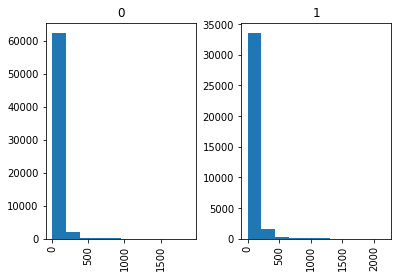

In [48]:
rr_as_df['answer_word_count'].hist(by=rr_as_df['accepted_flag'])

Text(0, 0.5, 'Accepted Answer Flag')

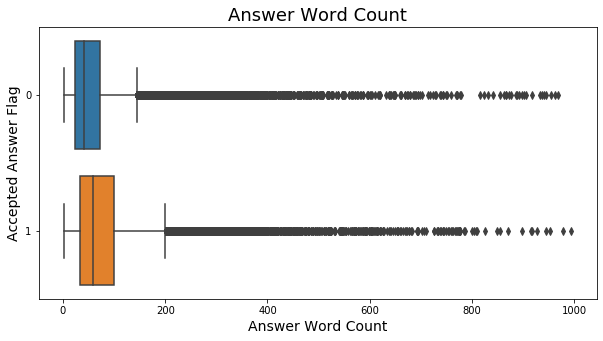

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'answer_word_count', y='accepted_flag',data = rr_as_df.loc[(rr_as_df['answer_word_count'] < 1000)] , orient="h")
plt.title('Answer Word Count', fontsize = 18)
plt.xlabel("Answer Word Count", fontsize = 14)
plt.ylabel("Accepted Answer Flag", fontsize = 14)

In [52]:
#Most common words in answers
pd.Series(' '.join(rr_as_df['answer']).lower().split()).value_counts()[:20]

p          280055
code       155882
codepre    131727
precode    107618
1           71355
_           57947
0           54014
import      46028
2           44802
use         44138
def         39402
python      36260
3           34572
return      34504
x           28933
nt          28258
print       25797
list        25097
gtgtgt      24792
using       24505
dtype: int64

In [53]:
#Number of unique words in answers
pd.Series(' '.join(rr_as_df['answer']).lower().split()).nunique()

627627